# Uncertainty on market shares

In [14]:
import brightway2 as bw
import bw2calc as bc
import bw2data as bd
import numpy as np
import pandas as pd
import presamples as ps
import scipy
import scipy.stats as stats
ps.__version__
import seaborn as sns

In [15]:
sns.set_style("darkgrid")

In [16]:
import pandas as pd
import re

# Your cleaning function
def clean_activity_string(raw_string):
    cleaned = raw_string.replace("'", "")
    
    generic_phrase = "to generic market for transport, freight, lorry, unspecified"
    cleaned = re.sub(re.escape(generic_phrase), "", cleaned, flags=re.IGNORECASE).strip()
    
    generic_phrase = "measured as solid wood under bark"
    cleaned = re.sub(re.escape(generic_phrase), "", cleaned, flags=re.IGNORECASE).strip()

    # Step 2: Replace long-form units with abbreviations
    unit_replacements = {
        "kilogram": "kg",
        "kilograms": "kg",
        "ton kilometer": "tkm",
        "tonne kilometer": "tkm",
        "megajoule": "MJ",
        "kilowatt hour": "kWh",
        "cubic meter": "m3",
        "square meter": "m2",
        "meter": "m",
        "second": "s",
    }
    for long, short in unit_replacements.items():
        cleaned = re.sub(rf'\b{long}\b', short, cleaned, flags=re.IGNORECASE)

    # Step 3: Remove ", None" from inside parentheses
    cleaned = re.sub(r',?\s*None\s*\)', ')', cleaned)

    return cleaned

# Ecoinvent: local versus global

In [17]:
Global_market= pd.read_csv("results/Global__market_for_sawnwood__board__softwood__raw__dried__u_20_____cubic_meter__CH__None__market_scores_20.csv")
Local_market= pd.read_csv("results/Local__market_for_sawnwood__board__softwood__raw__dried__u_20_____cubic_meter__CH__None__market_scores.csv")
products = pd.read_excel(r"run.xlsx", sheet_name='to_plot')


In [18]:
matched_df = Global_market.merge(Local_market, on='names', how='inner')

In [19]:
product_list = products['names']

In [20]:
product_list[0]

'_market_for_sawnwood__board__softwood__raw__dried__u_20_____cubic_meter__CH__None_'

In [21]:
Local_scores = []
for product in product_list:
    Local_market = pd.read_csv(f"results/Local_{product}_market_scores.csv")
    Local_scores.append(Local_market)
    
Global_scores = []
for product in product_list:
    Global_market = pd.read_csv(f"results/Global_{product}_market_scores_20.csv")
    Global_scores.append(Global_market)
    

In [22]:
Global_df = pd.concat(Global_scores, ignore_index=True)
Local_df = pd.concat(Local_scores, ignore_index=True)

matched_df = Global_df.merge(Local_df, on=['names', 'reference_product'], how='inner')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


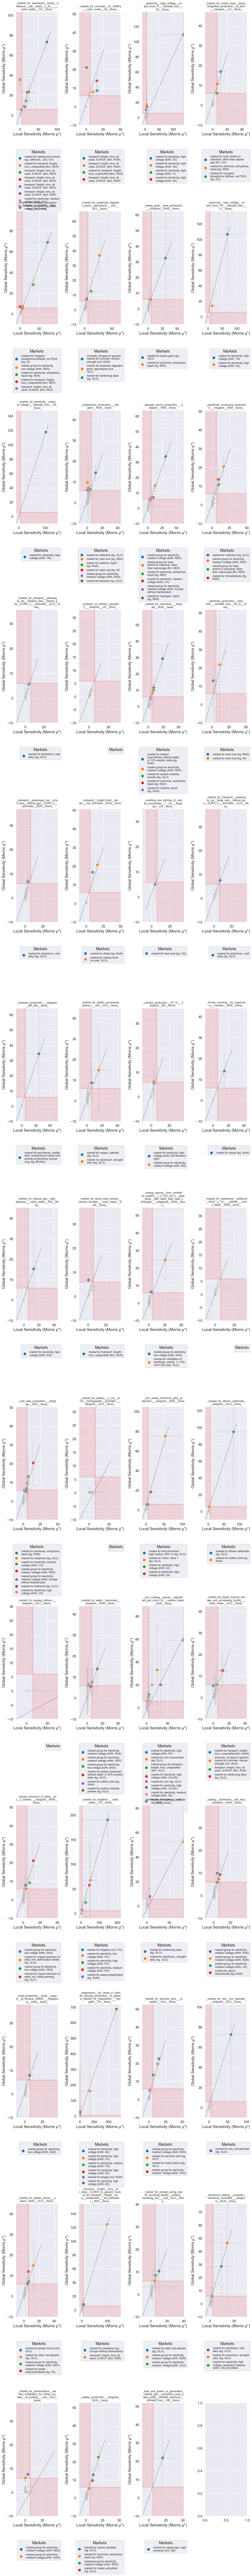

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import textwrap
import warnings

warnings.filterwarnings("ignore")
sns.set_style("darkgrid")

# Filter dataset and extract unique reference products
filtered_df = matched_df #.iloc[5:10]
filtered_df['names'] = filtered_df['names'].apply(clean_activity_string)
reference_products = filtered_df['reference_product'].unique()

# Create subplots
fig, axes = plt.subplots(nrows=13, ncols=4, figsize=(12, 120))
axes = axes.flatten()  # Flatten axes array for easy iteration

def add_newlines(text, n=3):
    """Wrap text to insert newlines every n words."""
    return '\n'.join(textwrap.wrap(text, width=n * 10))

# Iterate through each reference product
for ax, product in zip(axes, reference_products):
    product_df = filtered_df[filtered_df['reference_product'] == product]

    # Split into high and low global sensitivity groups
    high_global_df = product_df[product_df['mu_star_relative'] > 5]
    low_global_df = product_df[product_df['mu_star_relative'] <= 6]

    # Apply text wrapping
    high_global_df['names_with_newlines'] = high_global_df['names'].apply(add_newlines)
    product_with_newlines = add_newlines(product)

    # Dynamically set axis limits

    # Set axis limits dynamically
    x_min, x_max = product_df['mu_star_local_relative'].min(), product_df['mu_star_local_relative'].max()
    y_min, y_max = product_df['mu_star_relative'].min(), product_df['mu_star_relative'].max()

    ax.set_xlim(-10, y_max + 30)
    ax.set_ylim(-10, y_max + 30)
    # Plot high-sensitivity points with legend
    scatter_high = sns.scatterplot(
        x=high_global_df['mu_star_local_relative'], 
        y=high_global_df['mu_star_relative'], 
        hue=high_global_df['names_with_newlines'], 
        ax=ax, s=100, legend='brief'
    )
    scatter_high.legend(loc='upper right', bbox_to_anchor=(1.1, -0.2), title="Markets", fontsize=9)

    # Plot low-sensitivity points in grey without legend
    ax.scatter(
        low_global_df['mu_star_local_relative'], 
        low_global_df['mu_star_relative'], 
        color='#D3D3D3', alpha=0.6, s=10, label='_nolegend_'
    )

    # Plot diagonal reference line
    ax.plot([x_min - 10, x_max + 10], [y_min - 10, y_max + 10], linestyle="--", color="black", linewidth=0.6)

    # Set labels and title
    ax.set_xlabel("Local Sensitivity (Morris μ*)")
    ax.set_ylabel("Global Sensitivity (Morris μ*)")
    ax.set_title(f"{product_with_newlines}", fontsize=9)

    # Add error bars
    ax.errorbar(
        product_df['mu_star_local_relative'], 
        product_df['mu_star_relative'], 
        xerr=product_df['mu_star_local_relative_conf'] * 1.96, 
        yerr=product_df['mu_star_conf_relative'] * 1.96, 
        fmt='_', color='silver', alpha=0.6, capsize=3, capthick=1
    )

    # Add red threshold lines and shaded areas
    # Add red threshold lines and shaded areas
    ax.axvline(x=6, color='red', linestyle='--', linewidth=0.5)
    ax.axhline(y=6, color='red', linestyle='--', linewidth=0.5)
    ax.fill_betweenx(y=[6, 300], x1=x_min - 10, x2=6, color='red', alpha=0.1)
    ax.fill_betweenx(y=[-10, 6], x1=6, x2=x_max + 300, color='red', alpha=0.1)

# Adjust layout
fig.subplots_adjust(
    hspace=7,  # vertical space between rows
    wspace=0.5,  # horizontal space between columns
    top=0.95,    # top margin
    bottom=0.05, # bottom margin
    left=0.05,   # left margin
    right=0.95   # right margin
)
plt.tight_layout()

# Show and save the figure
plt.show()
fig.savefig("figures/local_vs_global_sensitivity_comparison_multiple_rows_3x2_with_legend.pdf", bbox_inches="tight")


In [24]:
reference_products = ['_market_for_sawnwood__board__softwood__raw__dried__u_20_____cubic_meter__CH__None_',
                       '_market_for_wood_wool_boards__cement_bonded___cubic_meter__RoW__None_',
                      '_market_for_inorganic_phosphorus_fertiliser__as_P2O5___kilogram__IS__None_',
                        '_market_for_concrete__25_30MPa___cubic_meter__IN__None_'
                     
                     
                     
                      ]

In [142]:
all_unique_names =['market for sawlog and veneer log, softwood,  (m3, CH)',
      'market for transport, freight, lorry, unspecified (tkm, RER)',
       'transport, freight, lorry, all sizes, EURO5  (tkm, RER)',
       'transport, freight, lorry, all sizes, EURO6  (tkm, RER)',
       'transport, freight, lorry, all sizes, EURO3  (tkm, RER)',
       'transport, freight, lorry, all sizes, EURO4  (tkm, RER)',
       'transport, freight, lorry, all sizes, EURO5  (tkm, RoW)',
       'transport, freight, lorry, all sizes, EURO3  (tkm, RoW)',
      'market for transport, freight, lorry, unspecified (tkm, RoW)',
       'transport, freight, lorry, all sizes, EURO4  (tkm, RoW)',
       'market for ammonia, anhydrous, liquid (kg, RER)',
       'market for inorganic phosphorus fertiliser, as P2O5 (kg, IS)',
       'market group for electricity, low voltage (kWh, RER)',

]

custom_titles = [ 'market for sawnwood \n board softwood raw dried \n u=20% 1 cubic meter CH',
                   'market for wood wool\n boards cement \nbonded m3 RoW',
                      'market for inorganic\n phosphorus \nfertiliser as P2O5 kg IS',
                        'market for concrete\n 25-30MPa m3 IN'
                     ] 

palette = [
     "#1f77b4",  # muted blue
    "#9467bd",  # muted purple
    "#ff7f0e",  # safety orange
    "#2ca02c",  # cooked asparagus green
    "yellow",  # brick red
    "#8c564b",  # chestnut brown
    "#e377c2",  # raspberry pink
    "#17becf",  # blue-teal
    "#d62728",  # brick red
    "#bcbd22",  # olive yellow-green
    "#7f7f7f",  # gray
    "#aec7e8",  # light blue
    "#ffbb78",  # light orange
    "#98df8a",  # light green
    "#ff9896",  # salmon pink
    "#c5b0d5",  # light purple
    "#c49c94",  # taupe
    "#f7b6d2",  # baby pink
    "#9edae5",  # light teal
    "#8c564b",  # deep brown (repeat but distinct enough)
    "#e41a1c",  # bright red
    "#1f77b4",  # muted blue
    "#9467bd",  # muted purple
    "red",  # safety orange
    "#d62728",  # brick red
    "#2ca02c",  # cooked asparagus green
    "#d62728",  # brick red
    "#8c564b",  # chestnut brown
    "red",  # raspberry yogurt pink
    "turquoise",  # middle gray
    "red",  
    "#17becf",   
    "yellow", 
    "blue",  
    "green" ,  
]

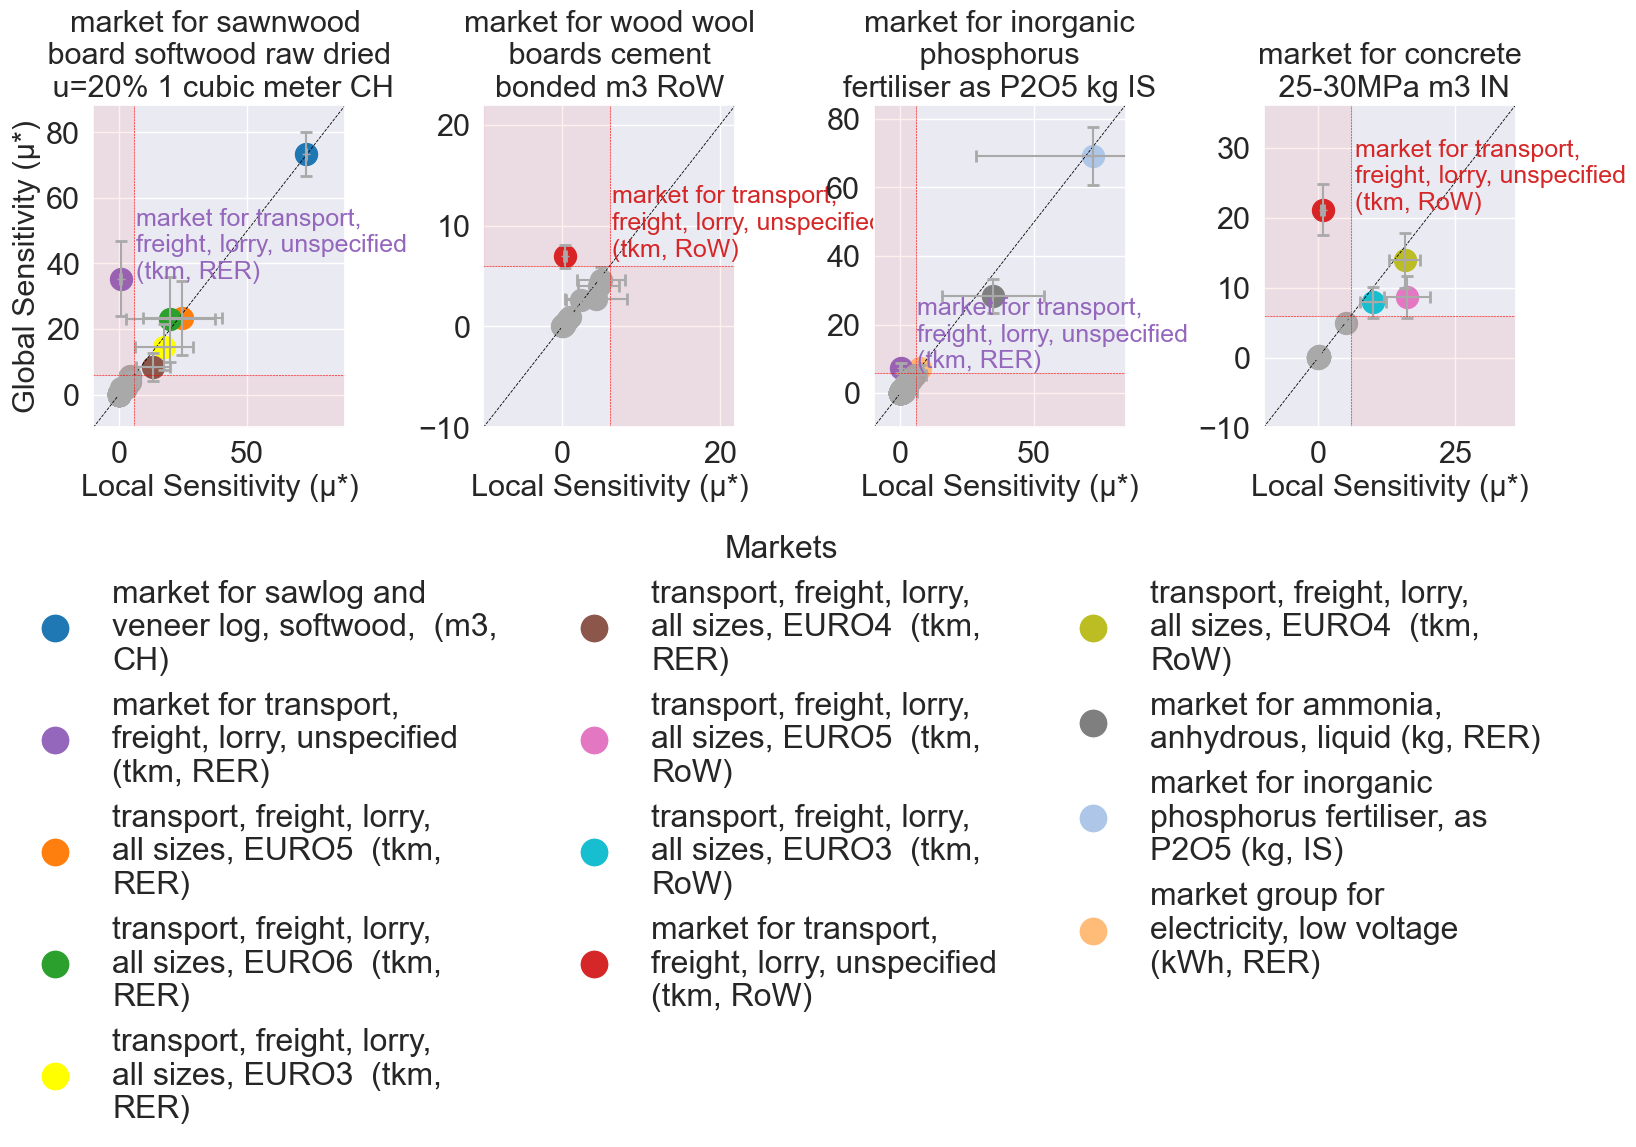

In [149]:
import matplotlib.lines as mlines
import textwrap
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

warnings.filterwarnings("ignore")
sns.set_style("darkgrid")
sns.set_context("notebook", font_scale=1)

# Filter dataset and extract unique reference products
filtered_df = matched_df.copy()
filtered_df['names'] = filtered_df['names'].apply(clean_activity_string)

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(22, 2.6))
axes = axes.flatten()

def add_newlines(text, n=3):
    """Wrap text to insert newlines every n words."""
    return '\n'.join(textwrap.wrap(text, width=n * 9))

# Collect all unique high-sensitivity names across all products
high_sensitivity_df = filtered_df[
    (filtered_df['mu_star_local_relative'] > 6)
]

#all_unique_names = high_sensitivity_df['names'].unique()
palette = palette[:len(all_unique_names)]
global_color_map = {name: palette[i] for i, name in enumerate(all_unique_names)}

# Create shared legend handles
global_handles = [
    mlines.Line2D([0], [0], marker='o', color='w', label=add_newlines(name),
                  markerfacecolor=global_color_map[name], markersize=21)
    for name in all_unique_names
]

# Plot each subplot
for i, (ax, product) in enumerate(zip(axes, reference_products)):
    product_df = filtered_df[filtered_df['reference_product'] == product]

    # Split into high and low global sensitivity groups
    high_global_df = product_df[product_df['mu_star_relative'] > 6]
    low_global_df = product_df[product_df['mu_star_relative'] <= 6]

    product_with_newlines = add_newlines(product)

    # Axis limits
    x_min, x_max = product_df['mu_star_local_relative'].min(), product_df['mu_star_local_relative'].max()
    y_min, y_max = product_df['mu_star_relative'].min(), product_df['mu_star_relative'].max()
    ax.set_xlim(-10, y_max + 15)
    ax.set_ylim(-10, y_max + 15)

    # Plot high-sensitivity points
    for _, row in high_global_df.iterrows():
        x_val = row['mu_star_local_relative']
        y_val = row['mu_star_relative']
        name = row['names']
        color = global_color_map[name]

        ax.scatter(x_val, y_val, color=color, s=250)
        if (x_min - 10) <= x_val <= 6:
            ax.text(x_val + 6, y_val, add_newlines(name), fontsize=18,
                    color=color, verticalalignment='baseline')

    # Plot low-sensitivity points in grey
    ax.scatter(
        low_global_df['mu_star_local_relative'],
        low_global_df['mu_star_relative'],
        color='darkgrey', alpha=1, s=250
    )


    # Diagonal reference line
    ax.plot([-10, 300], [-10, 300], linestyle="--", color="black", linewidth=0.6)

    # Labels and title
    ax.set_xlabel("Local Sensitivity (μ*)", fontsize=22)
    ax.set_ylabel("Global Sensitivity (μ*)" if i == 0 else "", fontsize=22)
    ax.set_title(custom_titles[i], fontsize=22)
    ax.tick_params(axis='y', labelsize=22)
    ax.tick_params(axis='x', labelsize=22)

    # Error bars
    ax.errorbar(
        product_df['mu_star_local_relative'],
        product_df['mu_star_relative'],
        xerr=product_df['mu_star_local_relative_conf'] * 1.96,
        yerr=product_df['mu_star_conf_relative'] * 1.96,
        fmt='_', color='darkgrey', alpha=1, capsize=4, capthick=2
    )

    # Red threshold lines and shaded regions
    ax.axvline(x=6, color='red', linestyle='--', linewidth=0.4)
    ax.axhline(y=6, color='red', linestyle='--', linewidth=0.4)
    ax.fill_betweenx(y=[6, 300], x1=x_min - 10, x2=6, color='red', alpha=0.06)
    ax.fill_betweenx(y=[-10, 6], x1=6, x2=x_max + 300, color='red', alpha=0.06)

# Add one shared legend outside the plotting area
legend =fig.legend(handles=global_handles, loc='lower center', title="Markets",
           fontsize=23, title_fontsize=23, bbox_to_anchor=(0.35,-2.5),  ncol=3)

# Adjust layout to make space for legend


legend.get_frame().set_facecolor('white')  # background color
legend.get_frame().set_edgecolor('white') 
plt.tight_layout(pad=0.05, rect=[0, 0, 0.7, 1.9])
plt.show()
fig.savefig("figures/local_vs_global_sensitivity.pdf", bbox_inches="tight")
